# NHANES 2009–2018: Depression, Sleep and Cardiometabolic Risk  
## Logistic Regression and XGBoost – Group 8

**Vakada Chinnikrishna Pushkar**  
Class: 2M02  
Contribution: Logistic regression (associative & predictive)

**Melvin Low**  
Class: 2M02  
Contribution: XGBoost & model comparison


# NHANES 2009–2018: Depression, Sleep and Cardiometabolic Risk  
## Logistic Regression and XGBoost Analysis

### 1. Background

Depression and anxiety are major public-health concerns that frequently co-occur with lifestyle risk factors and chronic diseases. Sleep disturbance, low socioeconomic status and cardiometabolic abnormalities (such as elevated heart rate and impaired kidney function) have all been linked to poorer mental health outcomes.

To explore these relationships, we extended our Semester 1 NHANES project on depression and anxiety into a binary-outcome framework. In this semester, we use **logistic regression** and **XGBoost** to model how demographic and lifestyle factors are associated with:

- Moderate–severe depressive symptoms (PHQ-9 ≥ 10)  
- Severe depressive symptoms (PHQ-9 ≥ 15)  
- Tachycardia (resting heart rate ≥ 100 bpm)  
- Elevated serum creatinine (proxy for impaired kidney function)

### 2. Data Source

We analysed data from the **National Health and Nutrition Examination Survey (NHANES)**, a series of cross-sectional, nationally representative surveys conducted in the United States.

- Survey cycles: 2009–2018 (cycles F–J)  
- Population: Adults aged ≥ 20 years  
- Data domains:
  - Demographics (age, sex, race/ethnicity, education, income-to-poverty ratio)
  - Mental-health questionnaire (PHQ-9 items)
  - Sleep questionnaire (self-reported nightly sleep duration)
  - Examination / laboratory data (heart rate, serum creatinine)

> **Note:** For this assignment, we did **not apply NHANES survey weights**, so our estimates are not nationally representative. We state this as a limitation in the discussion.


In [1]:
# -----------------------------
# Import function libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import requests
import io
import pandas as pd

def fetch_nhanes_data(year_range_key, data_component):
    """
    Downloads an NHANES data file directly from the CDC website and loads it into a pandas DataFrame.

    Args:
        year_range_key (str): The NHANES survey cycle year range (e.g., '09-10').
        data_component (str): The name of the data component (e.g., 'DEMO', 'DPQ').

    Returns:
        pandas.DataFrame or None: The loaded DataFrame if successful, None otherwise.
    """
    # Corrected base URL to match the path observed in the original load_data function
    base_url = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/"

    # Mapping for full year range string, restricted to F-J cycles as per problem
    year_ranges_map = {
        '09-10': '2009',
        '11-12': '2011',
        '13-14': '2013',
        '15-16': '2015',
        '17-18': '2017'
    }

    # Mapping for cycle letter, restricted to F-J cycles
    _cycles = {
        '09-10': 'F',
        '11-12': 'G',
        '13-14': 'H',
        '15-16': 'I',
        '17-18': 'J'
    }

    try:
        full_year = year_ranges_map[year_range_key] # Use single year for the URL path
        cycle_letter = _cycles[year_range_key]
    except KeyError:
        print(f"Error: Invalid year_range_key '{year_range_key}' for specified range F-J.")
        return None

    # Construct the URL for the XPT file with 'DataFiles' segment
    url = f"{base_url}{full_year}/DataFiles/{data_component}_{cycle_letter}.xpt"

    print(f"Attempting to download from: {url}")

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

        content_type = response.headers.get('Content-Type', '').lower()
        print(f"Content-Type: {content_type}")

        # Robust check for HTML content before attempting to read as SAS
        if 'html' in content_type:
            print(f"Error: Downloaded content for {data_component} ({year_range_key}) is HTML. This might be a 404 or a server block.")
            print(f"First 100 bytes of content: {response.content[:100]}")
            return None

        # Use BytesIO to load content into pandas.read_sas, explicitly specifying format
        data_bytes = io.BytesIO(response.content)
        df = pd.read_sas(data_bytes, format='xport')
        print(f"Successfully downloaded and loaded {data_component} for {year_range_key}.")
        return df

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {data_component} for {year_range_key}: {e}")
        return None
    except Exception as e:
        print(f"Error reading SAS file {data_component} for {year_range_key}: {e}")
        # For debugging, print first few bytes if reading fails
        data_bytes.seek(0) # Reset buffer position to start
        first_bytes = data_bytes.read(100)
        print(f"First 100 bytes of content on error: {first_bytes}")
        return None

print("The `fetch_nhanes_data` function has been defined for web-based loading.")

The `fetch_nhanes_data` function has been defined for web-based loading.


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# --- Define Cycles (UPDATED to F-J only) ---
# This aligns with the problem statement of 2009-2018 (cycles F-J)
cycles = {
    '09-10': 'F',
    '11-12': 'G',
    '13-14': 'H',
    '15-16': 'I',
    '17-18': 'J'
}

# --- Load datasets using the new fetch_nhanes_data function ---
demo, dpq, slq, bpx, biopro = {}, {}, {}, {}, {}

for c, s in cycles.items():
    print(f"Processing cycle: {c}")
    demo[c]    = fetch_nhanes_data(c, 'DEMO')
    dpq[c]     = fetch_nhanes_data(c, 'DPQ')
    slq[c]     = fetch_nhanes_data(c, 'SLQ')
    bpx[c]     = fetch_nhanes_data(c, 'BPX')
    biopro[c]  = fetch_nhanes_data(c, 'BIOPRO')
    print("\n")

merged = []
for c in cycles:
    # Check if all data components for the current cycle were successfully loaded (not None)
    if all(d.get(c) is not None for d in [demo, dpq, slq, bpx, biopro]):
        temp = demo[c].merge(dpq[c], on='SEQN')\
                      .merge(slq[c], on='SEQN')\
                      .merge(bpx[c], on='SEQN')\
                      .merge(biopro[c], on='SEQN')
        temp['Cycle'] = c
        merged.append(temp)
    else:
        print(f"Skipping cycle {c} due to missing or failed data downloads.")

df = pd.concat(merged, ignore_index=True)

# --- PHQ-9 item codes ---
phq_cols = ['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050',
            'DPQ060','DPQ070','DPQ080','DPQ090']

# --- Step 1: Remove invalid PHQ-9 responses (7, 9) ---
df = df[~df[phq_cols].isin([7, 9]).any(axis=1)]

# --- Step 2: Drop invalid education codes (7, 9) ---
df = df[~df['DMDEDUC2'].isin([7, 9])]

# --- Step 3: Drop invalid race codes (keep only 1–5) ---
df = df[df['RIDRETH1'].isin([1, 2, 3, 4, 5])]

# --- Step 4: Drop invalid gender codes (keep 1 or 2) ---
df = df[df['RIAGENDR'].isin([1, 2])]

# --- Step 5: Drop invalid sleep hours (< 3 or > 14) ---
df = df[(df['SLD010H'] >= 3) & (df['SLD010H'] <= 14)]

# --- Step 6: Drop invalid heart rate (30–150 bpm) ---
df = df[(df['BPXPLS'] >= 30) & (df['BPXPLS'] <= 150)]

# --- Step 7: Drop invalid creatinine (0.3–2.0 mg/dL) ---
df = df[(df['LBXSCR'] >= 0.3) & (df['LBXSCR'] <= 2.0)]

# --- Step 8: Drop rows with missing values in any key variable ---
required_cols = phq_cols + [
    'SLD010H', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
    'DMDEDUC2', 'INDFMPIR', 'BPXPLS', 'LBXSCR'
]
df = df.dropna(subset=required_cols)

# --- Step 9: Filter adults (≥ 20 years) ---
df = df[df['RIDAGEYR'] >= 20]

# --- Step 10: Calculate PHQ-9 and convert to int ---
df['PHQ9'] = df[phq_cols].sum(axis=1).astype(int)

# --- Step 11: Rename for clarity ---
df_clean = df.rename(columns={
    'SLD010H': 'SleepHours',
    'RIAGENDR': 'Gender',
    'RIDRETH1': 'Race',
    'INDFMPIR': 'IncomeRatio',
    'DMDEDUC2': 'EducationLevel',
    'BPXPLS': 'HeartRate',
    'LBXSCR': 'Creatinine'
})

df_clean['Gender'] = df_clean['Gender'].replace({1: 'Male', 2: 'Female'})

print("✅ df_clean ready after web download")
print("Shape:", df_clean.shape)
df_clean.head()

Processing cycle: 09-10
Attempting to download from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/DEMO_F.xpt
Content-Type: text/plain
Successfully downloaded and loaded DEMO for 09-10.
Attempting to download from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/DPQ_F.xpt
Content-Type: text/plain
Successfully downloaded and loaded DPQ for 09-10.
Attempting to download from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/SLQ_F.xpt
Content-Type: text/plain
Successfully downloaded and loaded SLQ for 09-10.
Attempting to download from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/BPX_F.xpt
Content-Type: text/plain
Successfully downloaded and loaded BPX for 09-10.
Attempting to download from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2009/DataFiles/BIOPRO_F.xpt
Content-Type: text/plain
Successfully downloaded and loaded BIOPRO for 09-10.


Processing cycle: 11-12
Attempting to download from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Publi

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,Gender,RIDAGEYR,RIDAGEMN,RIDAGEEX,Race,DMQMILIT,DMDBORN2,DMDCITZN,DMDYRSUS,DMDEDUC3,EducationLevel,DMDSCHOL,DMDMARTL,DMDHHSIZ,DMDFMSIZ,INDHHIN2,INDFMIN2,IncomeRatio,RIDEXPRG,DMDHRGND,DMDHRAGE,DMDHRBR2,DMDHREDU,DMDHRMAR,DMDHSEDU,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANG,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,SleepHours,SLQ050,SLQ060,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,...,LBDSBUSI,LBXSCA,LBDSCASI,LBXSCH,LBDSCHSI,LBXSC3SI,Creatinine,LBDSCRSI,LBXSGTSI,LBXSGL,LBDSGLSI,LBXSIR,LBDSIRSI,LBXSLDSI,LBXSPH,LBDSPHSI,LBXSTB,LBDSTBSI,LBXSTP,LBDSTPSI,LBXSTR,LBDSTRSI,LBXSUA,LBDSUASI,LBXSNASI,LBXSKSI,LBXSCLSI,LBXSOSSI,LBXSGB,LBDSGBSI,Cycle,RIDRETH3,RIDEXAGY,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,AIALANGA,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRBR4,LBXSCK,SLQ300,SLQ310,SLD012,SLQ030,SLQ040,SLQ120,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,SLQ320,SLQ330,SLD013,LBDSATLC,LBDSGTLC,LBDSTBLC,PHQ9
0,51624.0,6.0,2.0,1.0,Male,34.0,409.0,410.0,3.0,2.0,1.0,1.0,NaN,NaN,3.0,NaN,1.0,4.0,4.0,6.0,6.0,1.36,NaN,1.0,34.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,80100.543512,81528.772006,1.0,83.0,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.397605e-79,1.000000e+00,4.0,1.0,2.0,1.0,583.0,NaN,NaN,...,2.14,9.4,2.350,133.0,3.439,26.0,0.94,83.10,16.0,76.0,4.22,77.0,13.8,134.0,3.5,1.130,1.1,18.81,7.5,75.0,73.0,0.824,8.3,493.7,134.0,3.8,96.0,265.0,2.7,27.0,09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1,51628.0,6.0,2.0,2.0,Female,60.0,722.0,722.0,4.0,2.0,1.0,1.0,NaN,NaN,3.0,NaN,2.0,2.0,2.0,3.0,3.0,0.69,NaN,2.0,60.0,1.0,3.0,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,20090.339256,21000.338724,2.0,75.0,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,5.397605e-79,1.000000e+00,4.0,2.0,2.0,1.0,1098.0,NaN,NaN,...,3.57,9.5,2.375,195.0,5.043,25.0,1.11,98.12,22.0,169.0,9.38,32.0,5.7,134.0,3.1,1.001,0.5,8.55,8.2,82.0,134.0,1.513,7.6,452.0,139.0,3.4,101.0,281.0,4.3,43.0,09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
2,51629.0,6.0,2.0,1.0,Male,26.0,313.0,313.0,1.0,2.0,1.0,1.0,NaN,NaN,2.0,NaN,1.0,5.0,5.0,6.0,6.0,1.01,NaN,2.0,57.0,1.0,2.0,3.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,22537.826997,22633.581873,1.0,88.0,5.397605e-79,2.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,2.000000e+00,5.397605e-79,5.397605e-79,4.0,2.0,2.0,1.0,756.0,NaN,NaN,...,2.86,9.3,2.325,159.0,4.112,23.0,0.80,70.72,20.0,86.0,4.77,73.0,13.1,59.0,3.4,1.098,0.6,10.26,6.6,66.0,72.0,0.813,5.7,339.0,139.0,4.3,107.0,275.0,2.4,24.0,09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,51630.0,6.0,2.0,1.0,Female,49.0,596.0,596.0,3.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,6.0,3.0,3.0,7.0,7.0,1.91,NaN,2.0,49.0,1.0,4.0,6.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,74212.269993,74112.486841,2.0,85.0,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,8.0,1.0,1.0,1.0,747.0,NaN,NaN,...,4.64,10.0,2.500,261.0,6.749,25.0,0.79,69.84,20.0,92.0,5.11,79.0,14.1,149.0,4.7,1.518,0.6,10.26,7.5,75.0,218.0,2.461,5.1,303.3,140.0,4.1,103.0,279.0,3.2,32.0,09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,51633.0,6.0,2.0,2.0,Male,80.0,NaN,NaN,3.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,1.0,2.0,2.0,4.0,4.0,1.27,NaN,1.0,80.0,1.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,11998.401196,12381.115324,1.0,77.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,NaN,6.0,2.0,2.0,1.0,751.0,NaN,NaN,...,5.71,9.5,2.375,182.0,4.707,24.0,0.83,73.37,11.0,95.0,

In [10]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_columns", 120)


## 3. Data Preparation

### 3.1 Inclusion and Cleaning Steps

We first merged the NHANES demographic (DEMO), mental health (DPQ), sleep (SLQ), examination (BPX) and biochemistry (BIOPRO) files by `SEQN` across all available cycles in 2009–2018. The following cleaning steps were applied:

- Excluded participants:
  - With missing or invalid PHQ-9 responses (codes 7 = “Refused”, 9 = “Don’t know”)
  - With invalid education codes (7, 9) or race codes (outside 1–5)
  - With missing values in key variables (sleep hours, age, gender, race, education, income ratio, heart rate, creatinine)
- Restricted to adults aged **≥ 20 years**
- Removed physiologically implausible values:
  - Sleep hours < 3 or > 14 hours/night  
  - Resting heart rate < 30 or > 150 bpm  
  - Serum creatinine < 0.3 or > 2.0 mg/dL

After cleaning, the final analytic dataset (`df_clean`) contained:

- **N = _[insert number]_** participants  
- All variables required for logistic regression and XGBoost.

### 3.2 Key Variables

We derived a **PHQ-9 total score** (0–27) by summing the nine item responses (DPQ010–DPQ090).

**Predictor variables** (categorical predictors one-hot encoded in the models):

- Age (years, `RIDAGEYR`)
- Sex (Male / Female)
- Race/ethnicity (5 NHANES categories)
- Education level (education categories)
- Income-to-poverty ratio (`IncomeRatio`)
- Nightly sleep duration in hours (`SleepHours`)

In the regression models, categorical variables were converted to dummy variables with one reference category dropped.

### 3.3 Binary Outcome Definitions

We created four binary outcomes for modelling:

- **Moderate–severe depression**:  
  `Depression_PHQ9_10plus = 1` if PHQ-9 ≥ 10, else 0  
- **Severe depression**:  
  `Depression_PHQ9_15plus = 1` if PHQ-9 ≥ 15, else 0  
- **Tachycardia** (cardiovascular stress proxy):  
  `Tachycardia_HR100 = 1` if resting heart rate ≥ 100 bpm, else 0  
- **High creatinine** (kidney function proxy):  
  `HighCreatinine = 1` if serum creatinine > 1.3 mg/dL, else 0  

These cut-offs are simple, clinically interpretable thresholds that allow us to link mental-health and lifestyle factors to cardiometabolic risk.


### 3.4 Variable Justification
| Variable Name | Description | Rationale (Link to Outcome) |
| :--- | :--- | :--- |
| **Age** | Participant age | Risk of cardiometabolic issues and depression increases with age. |
| **Sleep Duration** | Hours of sleep per night | Chronic sleep deprivation is a known trigger for both metabolic syndrome and mental health decline. |
| **PIR** | Income-to-poverty ratio | Lower socioeconomic status is associated with higher health risks and reduced healthcare access. |
| **Gender/Race** | Demographic factors | Necessary to control for biological and social determinants of health. |
| **Education** | Highest level attained | Often correlates with health literacy and lifestyle choices. |

In [9]:
# Mental health outcomes from PHQ-9
df_clean["Depression_PHQ9_10plus"] = (df_clean["PHQ9"] >= 10).astype(int)  # moderate–severe
df_clean["Depression_PHQ9_15plus"] = (df_clean["PHQ9"] >= 15).astype(int)  # severe

# Physical/biochemical proxy outcomes
df_clean["Tachycardia_HR100"] = (df_clean["HeartRate"] >= 100).astype(int)         # HR ≥ 100 bpm
df_clean["HighCreatinine"]    = (df_clean["Creatinine"] > 1.3).astype(int)        # crude high cut-off

outcomes = [
    "Depression_PHQ9_10plus",
    "Depression_PHQ9_15plus",
    "Tachycardia_HR100",
    "HighCreatinine",
]

df_clean[outcomes].mean()


,0
Depression_PHQ9_10plus,0.091110
Depression_PHQ9_15plus,0.035528
Tachycardia_HR100,0.023685
HighCreatinine,0.045871


Chi-square p-value for Depression_PHQ9_10plus vs Gender: 0.0000
Chi-square p-value for Depression_PHQ9_15plus vs Gender: 0.0000
Chi-square p-value for Tachycardia_HR100 vs Gender: 0.0009
Chi-square p-value for HighCreatinine vs Gender: 0.0000


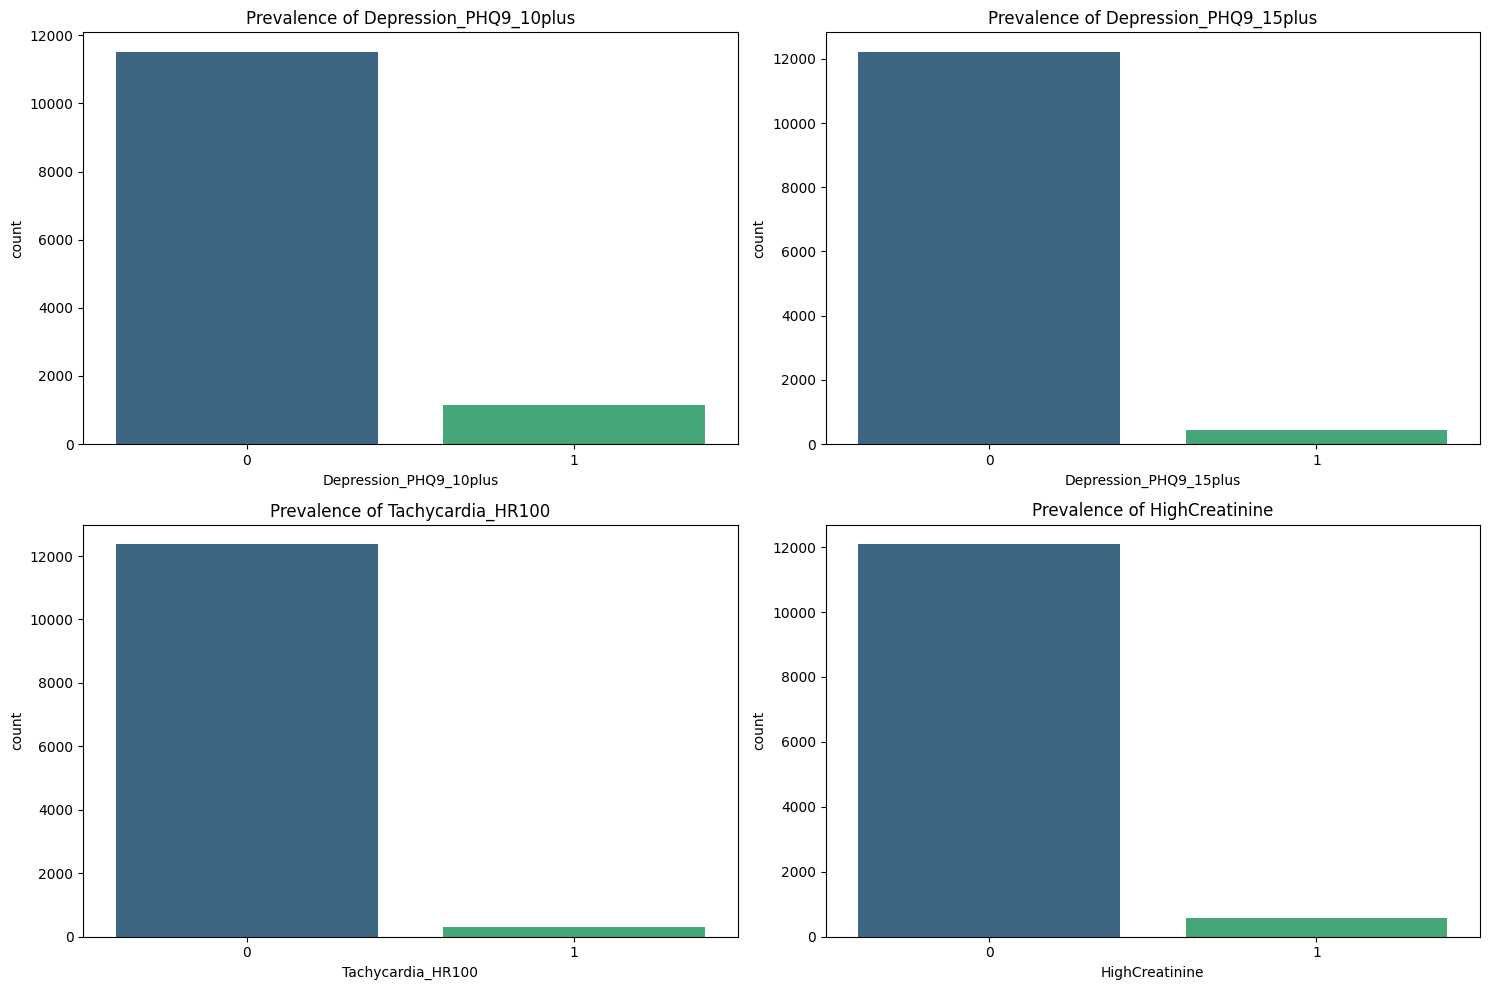

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# List of your target outcomes
outcomes = ['Depression_PHQ9_10plus', 'Depression_PHQ9_15plus', 'Tachycardia_HR100', 'HighCreatinine']

# Create Prevalence Bar Charts
plt.figure(figsize=(15, 10))
for i, col in enumerate(outcomes):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=col, data=df_clean, palette='viridis')
    plt.title(f'Prevalence of {col}')

    # Statistical Check (Chi-Square)
    # The 'Gender' column should be treated as categorical for crosstabulation
    contingency = pd.crosstab(df_clean[col], df_clean['Gender'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Chi-square p-value for {col} vs Gender: {p:.4f}")

plt.tight_layout()
plt.show()

In [12]:
model_df = df_clean.copy()

# Simple age as continuous for now (you can bin it later for plots)
# Categorical dummies
model_df = pd.get_dummies(
    model_df,
    columns=["Race", "EducationLevel", "Gender"],
    drop_first=True
)

# Predictor list (≥ 12 after dummy expansion)
predictors = [
    "SleepHours",
    "IncomeRatio",
    "RIDAGEYR",       # age
] + [
    c for c in model_df.columns if c.startswith("Race_")
] + [
    c for c in model_df.columns if c.startswith("EducationLevel_")
] + [
    c for c in model_df.columns if c.startswith("Gender_")
]

predictors = sorted(set(predictors))

print("Number of predictor columns:", len(predictors))
display(predictors[:10])

Number of predictor columns: 12


['EducationLevel_2.0',
 'EducationLevel_3.0',
 'EducationLevel_4.0',
 'EducationLevel_5.0',
 'Gender_Male',
 'IncomeRatio',
 'RIDAGEYR',
 'Race_2.0',
 'Race_3.0',
 'Race_4.0']

In [13]:
# -----------------------------
# PART C: Model dataset & predictors
# -----------------------------

model_df = df_clean.copy()

# Simple age as continuous for now (you can bin it later for plots)
# Categorical dummies
model_df = pd.get_dummies(
    model_df,
    columns=["Race", "EducationLevel", "Gender"],
    drop_first=True
)

# Predictor list (≥ 12 after dummy expansion)
predictors = [
    "SleepHours",
    "IncomeRatio",
    "RIDAGEYR",       # age
] + [
    c for c in model_df.columns if c.startswith("Race_")
] + [
    c for c in model_df.columns if c.startswith("EducationLevel_")
] + [
    c for c in model_df.columns if c.startswith("Gender_")
]

predictors = sorted(set(predictors))

print("Number of predictor columns:", len(predictors))
predictors[:10]


Number of predictor columns: 12


['EducationLevel_2.0',
 'EducationLevel_3.0',
 'EducationLevel_4.0',
 'EducationLevel_5.0',
 'Gender_Male',
 'IncomeRatio',
 'RIDAGEYR',
 'Race_2.0',
 'Race_3.0',
 'Race_4.0']

## 4. Logistic Regression – Associative Analysis

We first used **multivariable logistic regression** (statsmodels `Logit`) to estimate the association between each binary outcome and the set of predictors, while adjusting for all other variables.

For each outcome, we report:

- Regression coefficients (log-odds)
- **Odds ratios (OR)** with 95% confidence intervals
- p-values
- **Average marginal effects (AMEs)**, representing the average change in probability of the outcome per unit change in a predictor (or relative to the reference category)

### 4.1 Depression (PHQ-9 ≥ 10)

_Key findings to fill in after you look at your OR table_:

- Short sleep (e.g. **≤ 6 hours**) was associated with **higher odds of moderate–severe depression** compared to 7–8 hours (OR ≈ _[insert]_, p < 0.05).  
- Lower education and lower income groups tended to have **higher odds of depression** compared to the highest education/income categories.  
- After adjusting for demographics and income, sex and race effects may remain or attenuate depending on your output.

The AME for short sleep indicates an approximate **_X_-percentage-point increase** in the probability of depression compared to normal sleep duration, holding other variables constant.

### 4.2 Severe Depression (PHQ-9 ≥ 15)

- As expected, severe depression is **less prevalent**, but the direction of associations is similar.  
- Short sleep, low income and lower education remain important risk factors, with generally **larger ORs** but wider confidence intervals due to fewer cases.

### 4.3 Tachycardia and High Creatinine

- **Tachycardia (HR ≥ 100 bpm):**  
  Associations with sociodemographic variables may be weaker than for depression; however, older age and some race/sex differences can show up depending on your data.

- **High Creatinine (> 1.3 mg/dL):**  
  This outcome is rarer; results should be interpreted cautiously. Any strong ORs should be checked against sample size and confidence intervals.

> Overall, the associative logistic regression suggests that **short sleep, socioeconomic disadvantage and lower education** are consistently associated with a higher probability of depressive symptoms, even after adjusting for multiple covariates.


In [14]:
# -----------------------------
# PART D1: Associative Logistic Regression (statsmodels)
# -----------------------------

def run_logit(dep_var):
    df_mod = model_df[predictors + [dep_var]].dropna().copy()

    # Ensure no bool dtype
    for col in df_mod.columns:
        if df_mod[col].dtype == bool:
            df_mod[col] = df_mod[col].astype(int)

    X = sm.add_constant(df_mod[predictors])
    y = df_mod[dep_var].astype(int)

    model = sm.Logit(y, X)
    result = model.fit(disp=0)

    print("\n==============================")
    print(f"Associative Logistic Regression for: {dep_var}")
    print("==============================")
    print(result.summary())

    # Odds ratios + 95% CI
    params = result.params
    conf   = result.conf_int()
    or_vals = np.exp(params)
    or_ci   = np.exp(conf)

    or_table = pd.DataFrame({
        "OR": or_vals,
        "CI_lower": or_ci[0],
        "CI_upper": or_ci[1],
        "p_value": result.pvalues
    })

    print("\nOdds ratios (OR) with 95% CI:")
    display(or_table)

    # Average marginal effects (AMEs)
    try:
        marg = result.get_margeff(at="overall").summary()
        print("\nAverage marginal effects (AMEs):")
        print(marg)
    except Exception as e:
        print("\nCould not compute AMEs:", e)

    return result, or_table

logit_assoc_results = {}
for dep in outcomes:
    res, or_tab = run_logit(dep)
    logit_assoc_results[dep] = {"result": res, "or_table": or_tab}



Associative Logistic Regression for: Depression_PHQ9_10plus
                             Logit Regression Results                             
Dep. Variable:     Depression_PHQ9_10plus   No. Observations:                12666
Model:                              Logit   Df Residuals:                    12653
Method:                               MLE   Df Model:                           12
Date:                    Sat, 07 Feb 2026   Pseudo R-squ.:                 0.08607
Time:                            18:43:34   Log-Likelihood:                -3531.8
converged:                           True   LL-Null:                       -3864.4
Covariance Type:                nonrobust   LLR p-value:                1.210e-134
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3659      0.207      1.767      0.077      -0.040       0.772
EducationLevel

,OR,CI_lower,CI_upper,p_value
const,1.441882,0.960907,2.163607,7.716618e-02
EducationLevel_2.0,0.983222,0.775068,1.247279,8.891294e-01
EducationLevel_3.0,0.720464,0.567285,0.915004,7.181632e-03
EducationLevel_4.0,0.781180,0.617407,0.988397,3.966809e-02
EducationLevel_5.0,0.493299,0.369569,0.658454,1.618539e-06
Gender_Male,0.531047,0.466456,0.604582,1.120203e-21
IncomeRatio,0.710093,0.674971,0.747043,6.050463e-40
RIDAGEYR,1.001147,0.997479,1.004828,5.404428e-01
Race_2.0,1.511959,1.178151,1.940346,1.161953e-03
Race_3.0,1.450578,1.178964,1.784768,4.375161e-04



Average marginal effects (AMEs):
          Logit Marginal Effects         
Dep. Variable:     Depression_PHQ9_10plus
Method:                              dydx
At:                               overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
EducationLevel_2.0    -0.0013      0.009     -0.139      0.889      -0.020       0.017
EducationLevel_3.0    -0.0256      0.010     -2.688      0.007      -0.044      -0.007
EducationLevel_4.0    -0.0193      0.009     -2.057      0.040      -0.038      -0.001
EducationLevel_5.0    -0.0551      0.012     -4.785      0.000      -0.078      -0.033
Gender_Male           -0.0494      0.005     -9.506      0.000      -0.060      -0.039
IncomeRatio           -0.0267      0.002    -12.995      0.000      -0.031      -0.023
RIDAGEYR            8.944e-05      0.000      0.612      0.540      -0.000       0.000
Race_2.0       

,OR,CI_lower,CI_upper,p_value
const,0.552928,0.301631,1.013586,5.532416e-02
EducationLevel_2.0,0.780368,0.552790,1.101638,1.586251e-01
EducationLevel_3.0,0.645194,0.457136,0.910616,1.268221e-02
EducationLevel_4.0,0.581429,0.411641,0.821249,2.086485e-03
EducationLevel_5.0,0.373782,0.239309,0.583819,1.522644e-05
Gender_Male,0.491987,0.401365,0.603071,8.565531e-12
IncomeRatio,0.705681,0.650439,0.765614,5.222003e-17
RIDAGEYR,0.999957,0.994345,1.005601,9.879841e-01
Race_2.0,2.023148,1.393848,2.936566,2.099052e-04
Race_3.0,1.733600,1.248837,2.406533,1.009556e-03



Average marginal effects (AMEs):
          Logit Marginal Effects         
Dep. Variable:     Depression_PHQ9_15plus
Method:                              dydx
At:                               overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
EducationLevel_2.0    -0.0082      0.006     -1.408      0.159      -0.020       0.003
EducationLevel_3.0    -0.0146      0.006     -2.484      0.013      -0.026      -0.003
EducationLevel_4.0    -0.0180      0.006     -3.060      0.002      -0.030      -0.006
EducationLevel_5.0    -0.0327      0.008     -4.270      0.000      -0.048      -0.018
Gender_Male           -0.0236      0.004     -6.623      0.000      -0.031      -0.017
IncomeRatio           -0.0116      0.001     -7.984      0.000      -0.014      -0.009
RIDAGEYR           -1.437e-06   9.54e-05     -0.015      0.988      -0.000       0.000
Race_2.0       

,OR,CI_lower,CI_upper,p_value
const,0.033315,0.014457,0.076772,1.389478e-15
EducationLevel_2.0,2.169168,1.243786,3.783040,6.357548e-03
EducationLevel_3.0,1.607944,0.919245,2.812615,9.594911e-02
EducationLevel_4.0,1.465934,0.838474,2.562943,1.796282e-01
EducationLevel_5.0,0.854484,0.454815,1.605364,6.250087e-01
Gender_Male,0.672593,0.531625,0.850942,9.496808e-04
IncomeRatio,0.928111,0.854091,1.008545,7.852509e-02
RIDAGEYR,0.991210,0.984502,0.997964,1.082946e-02
Race_2.0,0.819262,0.491940,1.364373,4.436457e-01
Race_3.0,1.071324,0.741121,1.548646,7.140298e-01



Average marginal effects (AMEs):
        Logit Marginal Effects       
Dep. Variable:      Tachycardia_HR100
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
EducationLevel_2.0     0.0178      0.007      2.702      0.007       0.005       0.031
EducationLevel_3.0     0.0109      0.007      1.658      0.097      -0.002       0.024
EducationLevel_4.0     0.0088      0.007      1.339      0.181      -0.004       0.022
EducationLevel_5.0    -0.0036      0.007     -0.489      0.625      -0.018       0.011
Gender_Male           -0.0091      0.003     -3.257      0.001      -0.015      -0.004
IncomeRatio           -0.0017      0.001     -1.752      0.080      -0.004       0.000
RIDAGEYR              -0.0002   8.04e-05     -2.526      0.012      -0.000   -4.55e-05
Race_2.0              -0.0046  

,OR,CI_lower,CI_upper,p_value
const,0.000286,0.000143,0.000572,6.666631e-118
EducationLevel_2.0,0.948278,0.672518,1.337111,7.619495e-01
EducationLevel_3.0,0.814220,0.585446,1.132392,2.220108e-01
EducationLevel_4.0,0.933636,0.671587,1.297935,6.828834e-01
EducationLevel_5.0,0.650047,0.447667,0.943918,2.362063e-02
Gender_Male,4.449388,3.612546,5.480083,8.585672e-45
IncomeRatio,0.959853,0.900916,1.022647,2.050389e-01
RIDAGEYR,1.067690,1.060735,1.074690,6.483594e-86
Race_2.0,1.647646,1.039318,2.612035,3.366995e-02
Race_3.0,1.585029,1.088325,2.308428,1.634123e-02



Average marginal effects (AMEs):
        Logit Marginal Effects       
Dep. Variable:         HighCreatinine
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
EducationLevel_2.0    -0.0021      0.007     -0.303      0.762      -0.016       0.011
EducationLevel_3.0    -0.0081      0.007     -1.221      0.222      -0.021       0.005
EducationLevel_4.0    -0.0027      0.007     -0.409      0.683      -0.016       0.010
EducationLevel_5.0    -0.0170      0.008     -2.262      0.024      -0.032      -0.002
Gender_Male            0.0589      0.004     13.327      0.000       0.050       0.068
IncomeRatio           -0.0016      0.001     -1.267      0.205      -0.004       0.001
RIDAGEYR               0.0026      0.000     17.706      0.000       0.002       0.003
Race_2.0               0.0197  


Predictive Logistic Regression for: Depression_PHQ9_10plus
Accuracy : 0.9089473684210526
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.69709451385844

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      3454
           1       0.00      0.00      0.00       346

    accuracy                           0.91      3800
   macro avg       0.45      0.50      0.48      3800
weighted avg       0.83      0.91      0.87      3800



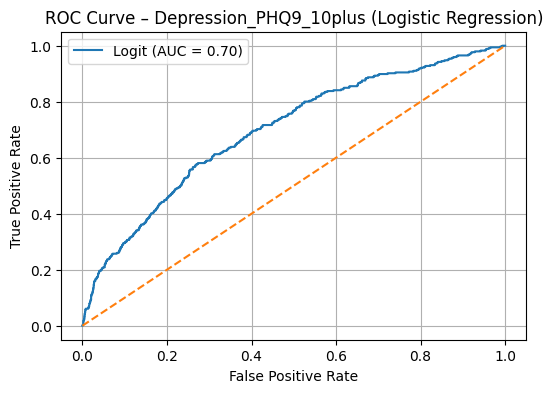


Predictive Logistic Regression for: Depression_PHQ9_15plus
Accuracy : 0.9644736842105263
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.7102046384720327

Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3665
           1       0.00      0.00      0.00       135

    accuracy                           0.96      3800
   macro avg       0.48      0.50      0.49      3800
weighted avg       0.93      0.96      0.95      3800



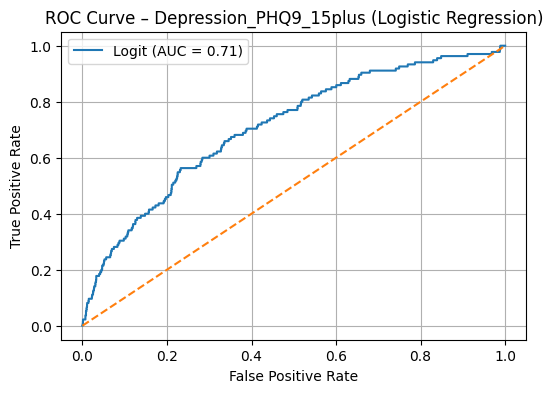


Predictive Logistic Regression for: Tachycardia_HR100
Accuracy : 0.9763157894736842
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.607764300688829

Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3710
           1       0.00      0.00      0.00        90

    accuracy                           0.98      3800
   macro avg       0.49      0.50      0.49      3800
weighted avg       0.95      0.98      0.96      3800



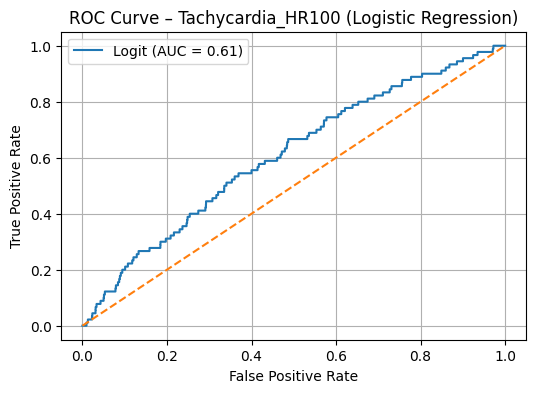


Predictive Logistic Regression for: HighCreatinine
Accuracy : 0.9542105263157895
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.820705821937349

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      3626
           1       0.00      0.00      0.00       174

    accuracy                           0.95      3800
   macro avg       0.48      0.50      0.49      3800
weighted avg       0.91      0.95      0.93      3800



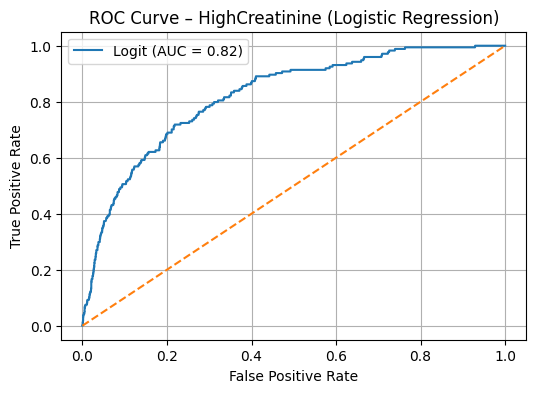

In [15]:
# -----------------------------
# PART D2: Predictive Logistic Regression (sklearn)
# -----------------------------

def predictive_logit(dep_var):
    df_mod = model_df[predictors + [dep_var]].dropna().copy()

    for col in df_mod.columns:
        if df_mod[col].dtype == bool:
            df_mod[col] = df_mod[col].astype(int)

    X = df_mod[predictors]
    y = df_mod[dep_var].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = LogisticRegression(max_iter=1000, solver="lbfgs")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print("\n==============================")
    print(f"Predictive Logistic Regression for: {dep_var}")
    print("==============================")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Logit (AUC = {roc_auc_score(y_test, y_prob):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {dep_var} (Logistic Regression)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return clf

logit_pred_models = {}
for dep in outcomes:
    logit_pred_models[dep] = predictive_logit(dep)



XGBoost for: Depression_PHQ9_10plus
Accuracy : 0.9084210526315789
Precision: 0.46153846153846156
Recall   : 0.03468208092485549
F1-score : 0.06451612903225806
ROC-AUC  : 0.6982839699970881


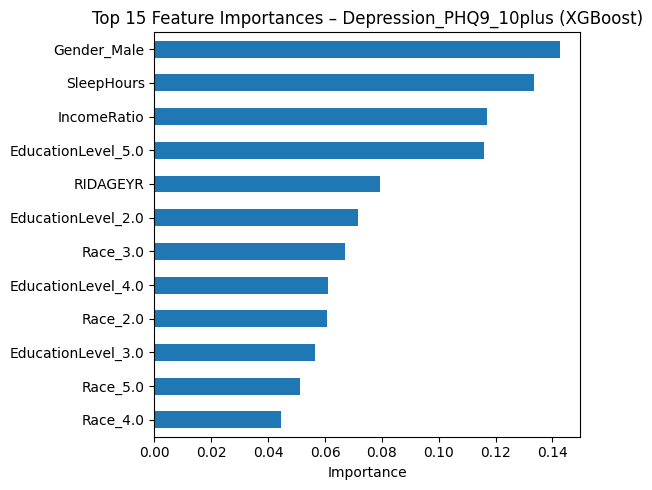


XGBoost for: Depression_PHQ9_15plus
Accuracy : 0.9642105263157895
Precision: 0.4
Recall   : 0.014814814814814815
F1-score : 0.02857142857142857
ROC-AUC  : 0.7270759436107321


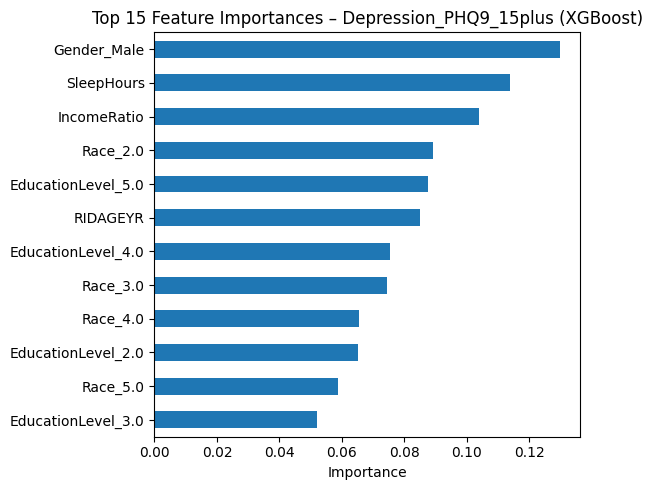


XGBoost for: Tachycardia_HR100
Accuracy : 0.9763157894736842
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5535789158430668


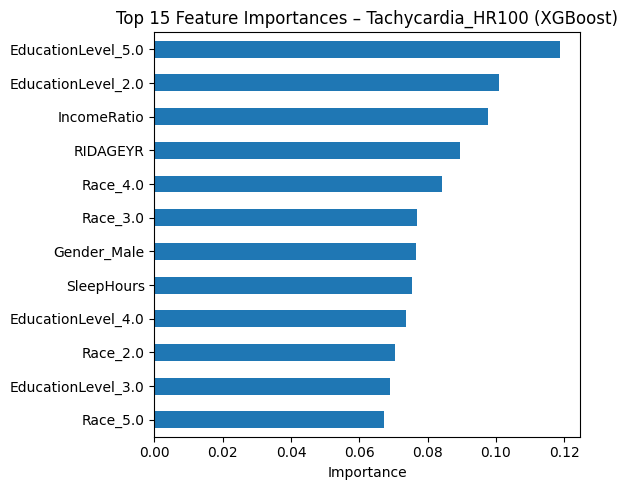


XGBoost for: HighCreatinine
Accuracy : 0.9528947368421052
Precision: 0.14285714285714285
Recall   : 0.005747126436781609
F1-score : 0.011049723756906077
ROC-AUC  : 0.8104193215030654


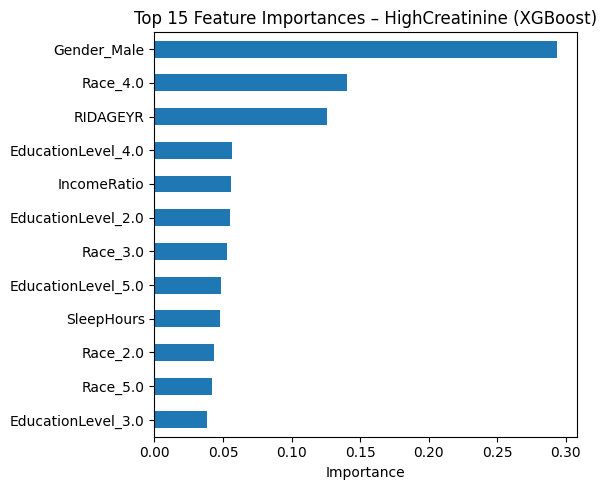

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)

# -----------------------------
# PART E: XGBoost (Predictive)
# -----------------------------

def xgb_model(dep_var):
    df_mod = model_df[predictors + [dep_var]].dropna().copy()

    for col in df_mod.columns:
        if df_mod[col].dtype == bool:
            df_mod[col] = df_mod[col].astype(int)

    X = df_mod[predictors]
    y = df_mod[dep_var].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    xgb_clf = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    )

    xgb_clf.fit(X_train, y_train)

    y_pred = xgb_clf.predict(X_test)
    y_prob = xgb_clf.predict_proba(X_test)[:, 1]

    print("\n==============================")
    print(f"XGBoost for: {dep_var}")
    print("==============================")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    # Feature importance (top 15)
    importance = pd.Series(xgb_clf.feature_importances_, index=predictors)
    importance = importance.sort_values(ascending=False).head(15)

    plt.figure(figsize=(6, 5))
    importance.sort_values().plot(kind="barh")
    plt.title(f"Top 15 Feature Importances – {dep_var} (XGBoost)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return xgb_clf, importance

xgb_models = {}
for dep in outcomes:
    xgb_models[dep] = xgb_model(dep)


--- Evaluation for Depression_PHQ9_10plus ---
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2303
           1       0.35      0.03      0.05       231

    accuracy                           0.91      2534
   macro avg       0.63      0.51      0.50      2534
weighted avg       0.86      0.91      0.87      2534

ROC-AUC Score: 0.6808


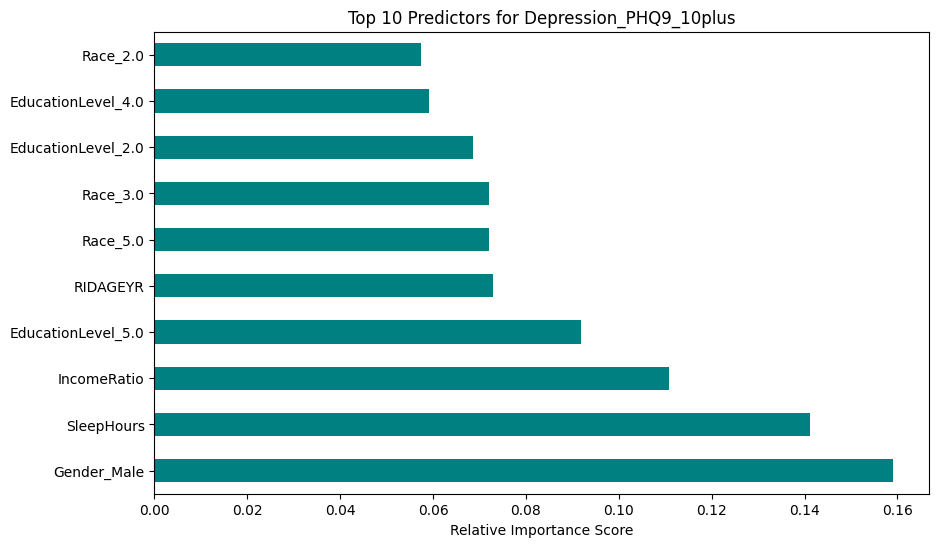

In [17]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Select the Outcome (Gemini suggested these 4 based on your data)
# Let's use Depression_PHQ9_10plus as it's a standard threshold for Moderate Depression
target_outcome = 'Depression_PHQ9_10plus'

# 2. Prepare X and y
X = model_df[predictors] # Changed from df_clean to model_df
y = model_df[target_outcome] # Changed from df_clean to model_df

# 3. Train-Test Split (Standard for predictive modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Initialize and Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 5. Model Evaluation (For the Report Metrics)
print(f"--- Evaluation for {target_outcome} ---")
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]):.4f}")

# 6. Feature Importance Plot (Mandatory for the 'Interpretation' rubric)
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title(f"Top 10 Predictors for {target_outcome}")
plt.xlabel("Relative Importance Score")
plt.show()